### 1. Sekcja odczytywania danych, określania typów danych cech.

In [170]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import matplotlib.pyplot as plt


target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
target_var_discr: str = "CO2 Emissions(g/km)_disc" #To jest nazwa zmiennej docelowej, która została poddana proceowi dyskretyzacji.

dtypes = { "Make": "category", #Określ typ danych każdej cechy w ramce danych, która zostanie zaraz odczytana.
            "Model":"category",
            "Vehicle Class":"category",
            "Engine Size(L)":"float",
            "Cylinders":"category",
            "Transmission":"category",
            "Fuel Type":"category",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}

def ReadDataFrame(filename:str, sep:str =';') -> tuple[pd.DataFrame, int]:
    global dtypes
   
    Dataset = pd.read_csv(filename,
                        sep=sep, dtype = dtypes, decimal = ",") #Wczytaj plik z danymi.

    n_rows:int  = Dataset.shape[0] #Liczba wszystkich wierszy w ramce danych

    return Dataset, n_rows




def FindTargetVarCol(Dataset:pd.DataFrame, target_var:str) -> np.ndarray:
    """Funkcja wybiera kolumne docelową z ramki danych, konwertuje ją na tablice numpy i zmienia liczbe jej wymiarów, tak
    aby zwrócona tablica była kompatybilna z modelami z sklearn'a."""

    return Dataset[target_var].to_numpy().reshape(-1,1)



Dataset, n_rows = ReadDataFrame("CO2Emission.csv")
target_var_col = FindTargetVarCol(Dataset, target_var)




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

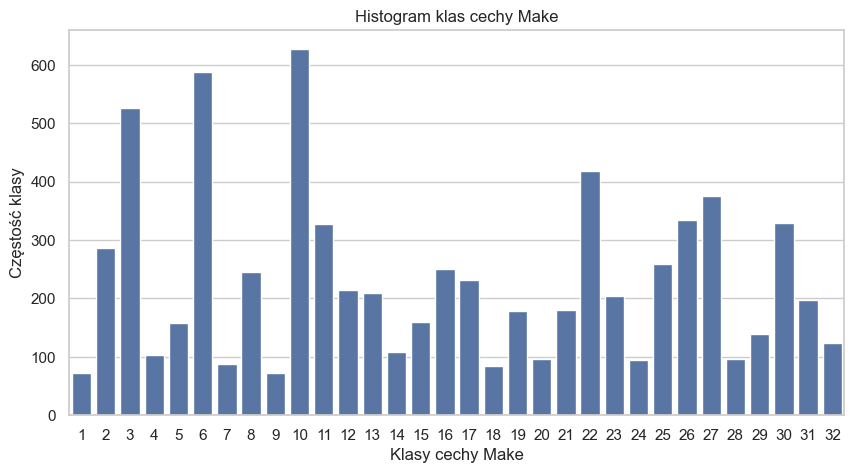

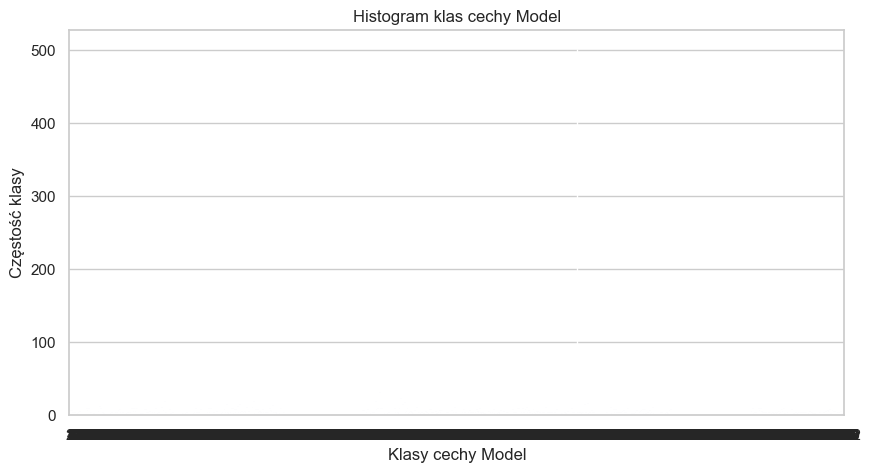

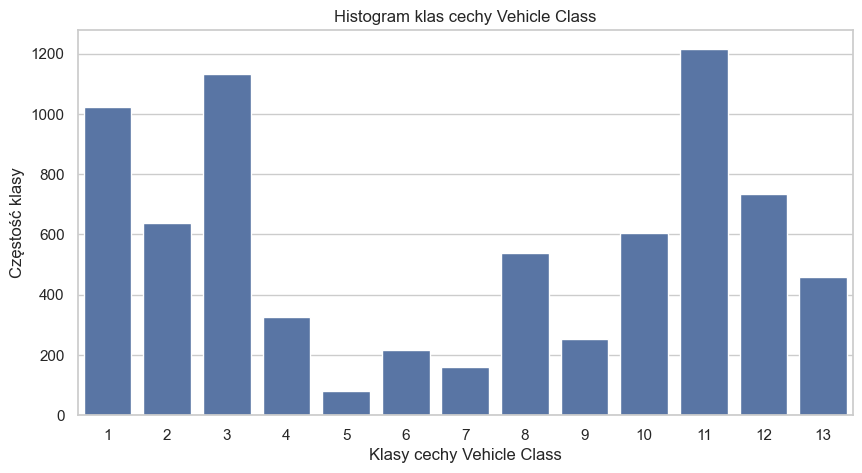

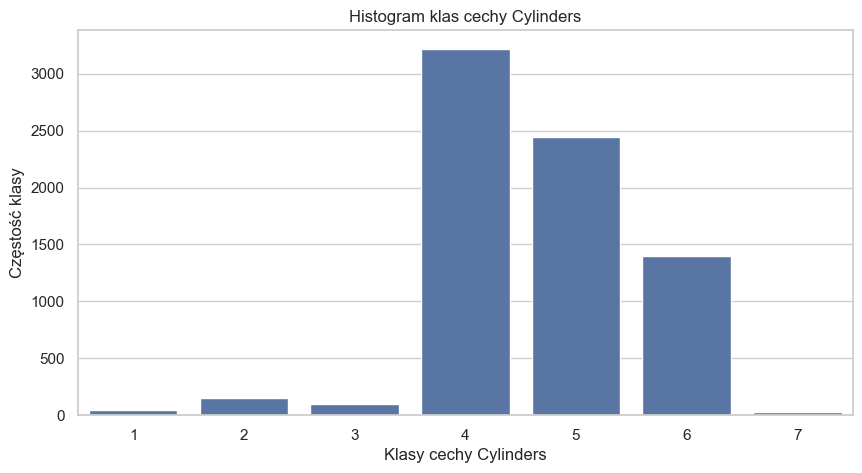

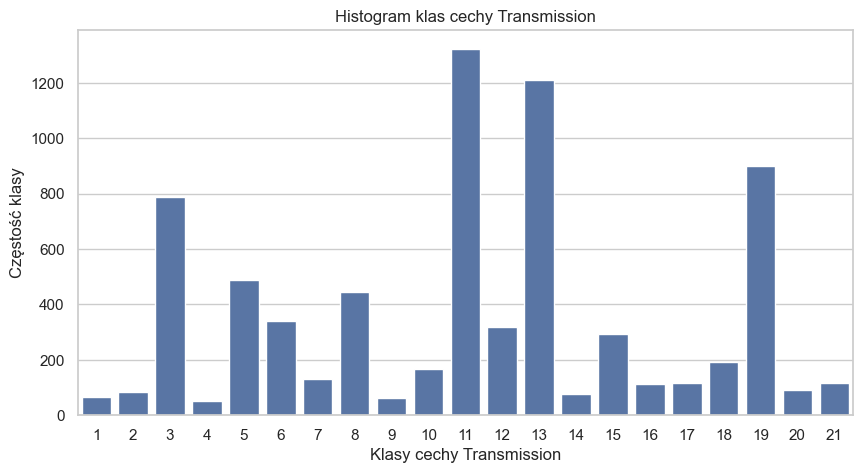

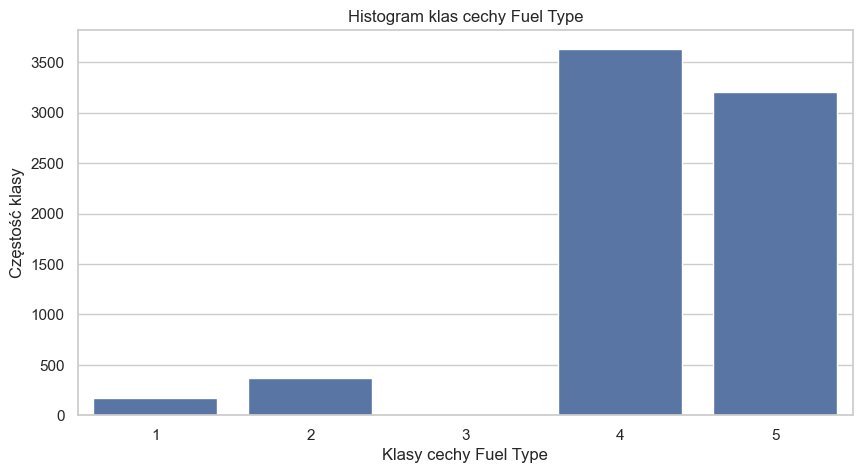

In [171]:
def CreateHistogram(Dataset:pd.DataFrame, CatFeature:str) ->  pd.DataFrame:
    """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
    Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
    Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
    """

    Histogram:pd.DataFrame = Dataset[CatFeature].value_counts(sort = False,).reset_index() #Stwórz proste podsumowanie częstotliwości występowania klas.

    return  Histogram

def CreateHistPlot(Histogram:pd.DataFrame, CatFeature:str) -> None:

    """Zadaniem tej funkcji jest stworzenie wykresu histogramowego, który opisze częstowliwość występowania wszystkich klas z cechy 'CatFeature'"""
    plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
 
    axes = sns.barplot(data = Histogram, x = f"{CatFeature}_coded", y = "count") #Czas na słupkowanie.

    axes.set_xlabel(f"Klasy cechy {CatFeature}") #Ustaw etykietkę poziomej osi.
    axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

    axes.set_title(f"Histogram klas cechy {CatFeature}") #Ustaw tytuł wykresu.

    axes.set_ylim(0, 1.05*np.max(Histogram['count']))

    

def AggregateRarestClass(Histogram:pd.DataFrame, CatFeature:str) -> pd.DataFrame:
    """Niektóre klasy danej cechy pojawią się bardzo rzadko. W tym celu niespotykane często klasy zagregujemy w jedną klasę o nazwie Other.
    Taki cel przyswięca funkcji tej. Klasa jest uznawana za rzadką, jeżeli liczba jej wystapień jest mniejsza niż frequency_threshold
    """
    frequecy_threshold:float = Histogram['count'].quantile(q = 0.25)

    Histogram[CatFeature] = Histogram.apply(func = lambda row: row[CatFeature] if row["count"]>=frequecy_threshold else "Other", 
                    axis = 1) #Klasy, które występują rzadziej niż frequency_threshold sklasyfikuj jako "other".
    

    Histogram:pd.DataFrame =   Histogram.groupby(by = CatFeature, 
                            as_index = False).agg(func = {"count":"sum"}) #Aktualnie w ramce Histogram tylko klasa "Other" może pojawiać się więcej 
                                                                            #Niż jeden raz. Zsumuj liczby wystąpień dla obserwacji, które są "inne".
    
    Unique_class_count:int = Histogram.shape[0]
    
    Histogram.insert(loc = 1, column = f"{CatFeature}_coded", value = range(1, Unique_class_count + 1 ))

    return Histogram


CatFeatures: list[str] = Dataset.select_dtypes(include = "category").columns #Znajdź listę wszystkich cech kategorycznych.

for CatFeature in CatFeatures:

    Histogram = CreateHistogram(Dataset = Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
                                CatFeature = CatFeature) 


    Histogram = AggregateRarestClass(Histogram = Histogram, 
                                     CatFeature = CatFeature) #Zagreguj rzadkie klasy.
    

    CreateHistPlot(Histogram = Histogram,  #Rysuj wykresik, bo kochamy wykresy.
                  CatFeature = CatFeature)



Pierwsze wnioski, jakie można wysunąć:


### Zmienna make może zostać skasowana. Nie jest ona dobrą zmienną, którą można uwzględnić w modela, z powodu ogromnej liczby unikatowych klas (ponad 2000), co czyni ją niemalże zmienną identyfikującą.

### Obserwacja, której typ paliwa to 3, może zostać pominięta. Występuje nienormalnie rzadko.

### Kasujemy zmienną Model oraz obserwację, której cecha "Fuel Type" wynosi N

In [172]:
def DeleteFutileColsAndObs(Dataset:pd.DataFrame):

    Dataset.drop(columns = ["Model"], inplace = True)

    Dataset = Dataset.query('`Fuel Type` != "N"')

    return Dataset
    

Dataset = DeleteFutileColsAndObs(Dataset)


### 3. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.
### Dodatkowo zbadamy współczynniki korelacji między tymi cechami ciągłymi.



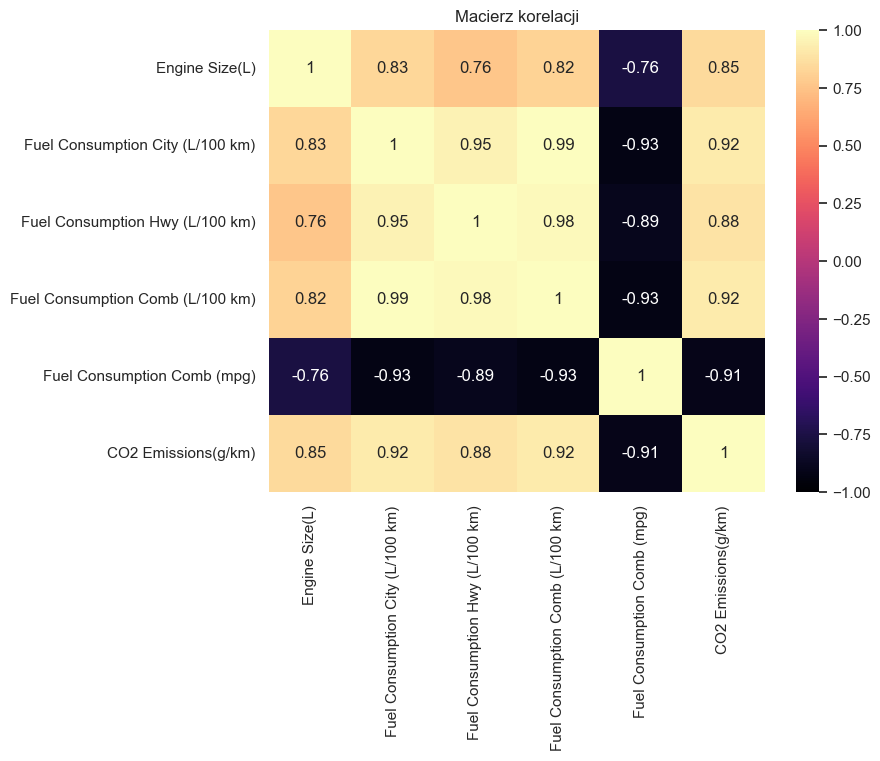

In [173]:
import seaborn as sns


def FindContFeatures(Dataset) -> list[str]:
    """Funkcja zwracaa listę nagłówków cech, które są typu floating-point
    """
    return Dataset.select_dtypes(include = "float").columns.to_numpy()



def CreatePairPlotCont(Dataset:pd.DataFrame, ContFeatures:list[str]) -> None:
    """Utwórz wykres parowy. (to znaczy - dla par zmiennych ciągłych) warunkowy ze względu na typ paliwa.
    """

    sns.pairplot(data = Dataset, vars = ContFeatures, hue = "Fuel Type")



def ComputeAndDrawCorrelationMatrix(Dataset:pd.DataFrame, Num_Features: list[str]) -> np.array:
    """Funkcja ta zajmuje się liczeniem macierzy korelacji między cechami numerycznymi. Dodatkowo, rysuje wykres cieplny, który
    obrazuje te relacje.
    """
    CorrMatrix:pd.DataFrame =  Dataset[Num_Features].corr(method = "pearson")

    plt.figure(figsize=(8, 6))

    sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
    plt.title('Macierz korelacji')
    plt.show()

    return CorrMatrix


ContFeatures = FindContFeatures(Dataset=Dataset)

#CreatePairPlotCont(Dataset, ContFeatures)
CorrMatrix = ComputeAndDrawCorrelationMatrix(Dataset, ContFeatures)

### 4. Dyskretyzacja zmiennej docelowej.

In [174]:

def Discretize(Dataset:pd.DataFrame, target_var:str, bins:list[float]) -> pd.Series:
    labels = [i for i in range(len(bins)+1)]
    bins = [-float("inf")] + bins + [float('inf')]


    discretized_feature = pd.cut(x = Dataset[target_var], 
                                 bins = bins, 
                                 labels = labels)


    Dataset[target_var_discr] = discretized_feature


Discretize(Dataset, target_var, [150, 200, 300])

### Tutaj zakończyliśmy czyszczenie kodu.


### 5. Warunkowe wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.

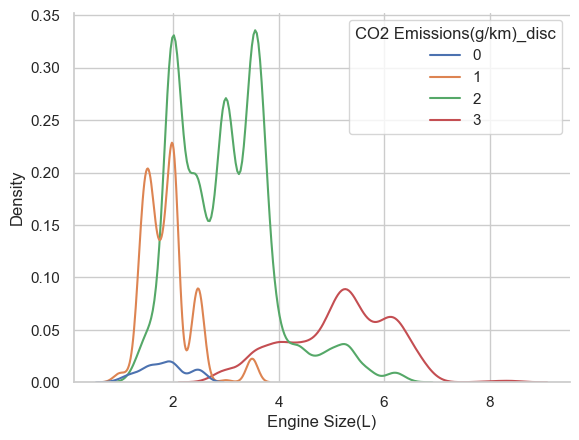

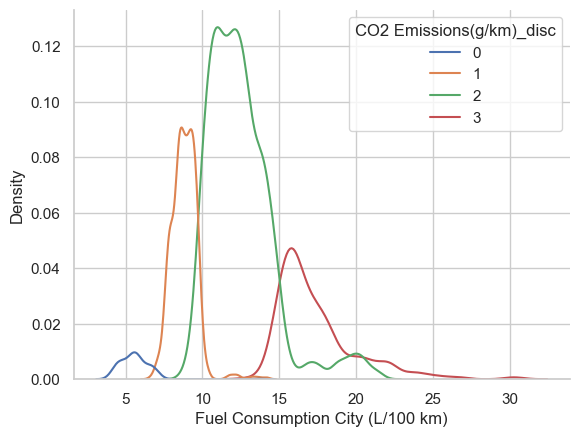

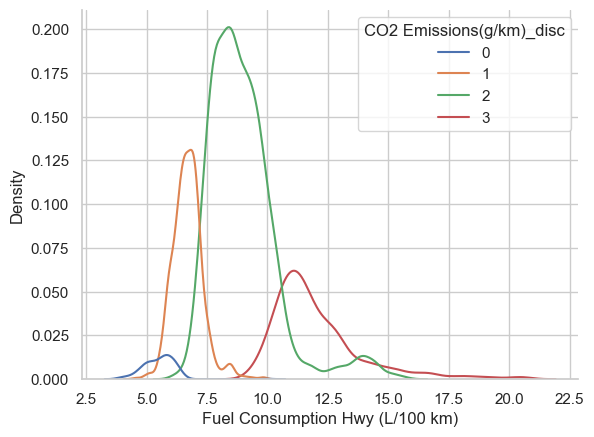

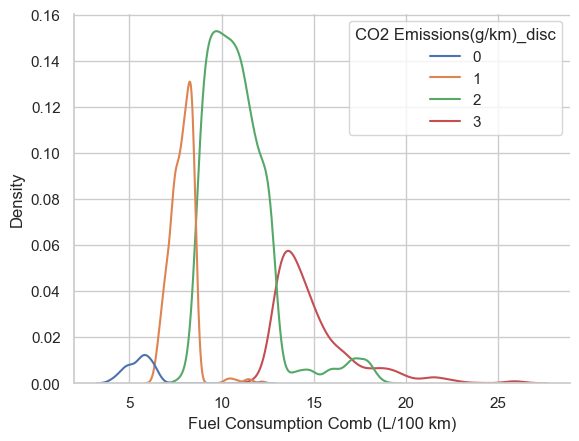

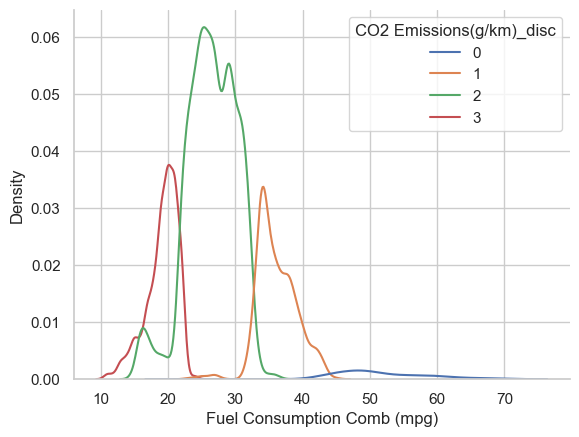

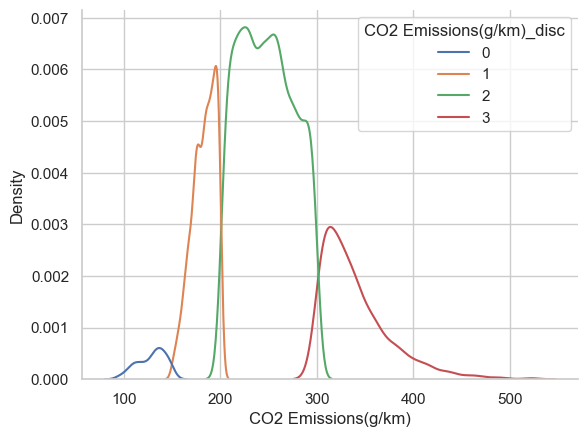

In [175]:
def StwórzWykresKDE(Dataset:pd.DataFrame, ContFeature:str, condfeature:str | None = None) -> plt.axes:
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.kdeplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres warunkowy.

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)

    return osie



for ContFeature in ContFeatures:    
    StwórzWykresKDE(Dataset, ContFeature, condfeature = target_var_discr)


### Dochodzimy do wniosku, że wszystkie cztery powyższe cechy ciągłe są bardzo dobrze dyskryminującę. Wykresy gęstości prawdopdoobieństwa dla każdej z cech ciągłych są praktycznie rozłączne, nie nachodzą na siebie.

### 6. Wykresy gęstości prawdopodobieństwa cia zmiennych ciągłych

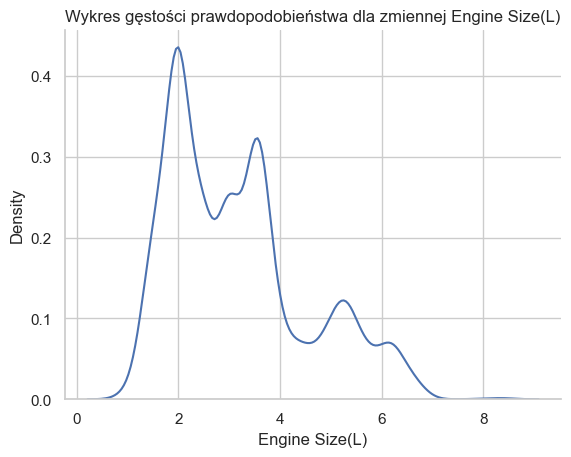

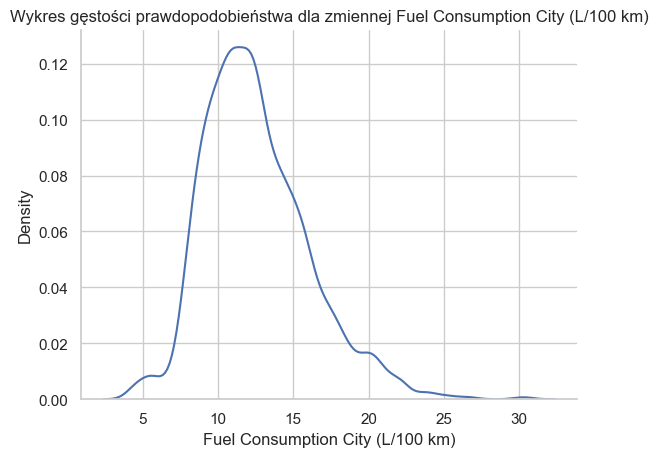

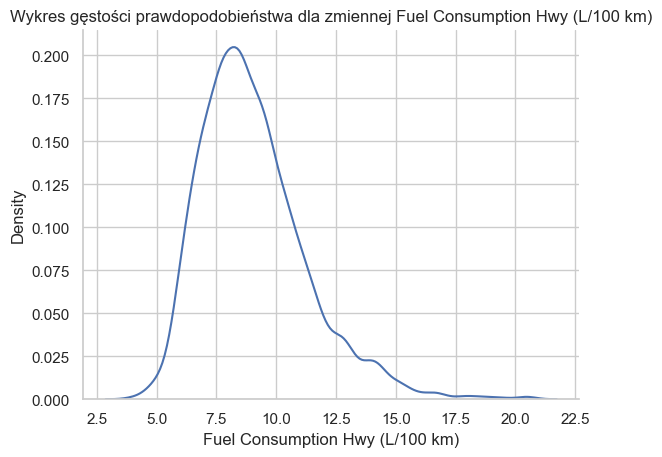

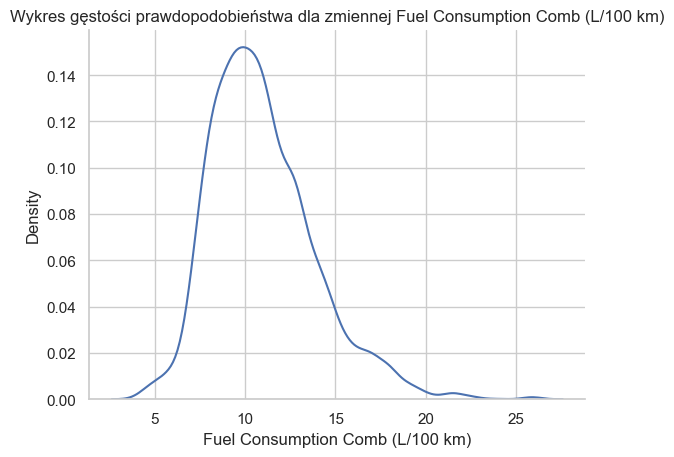

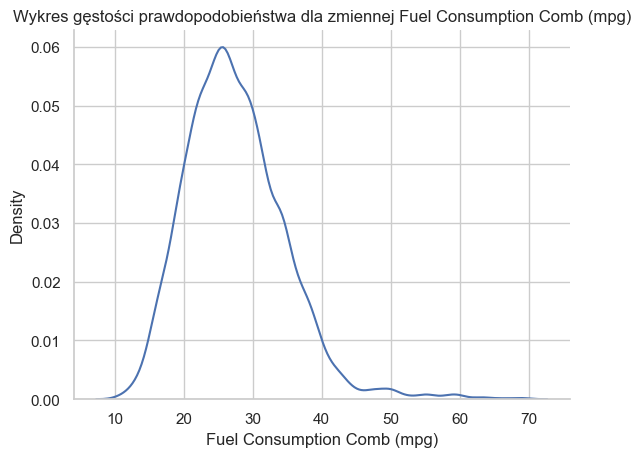

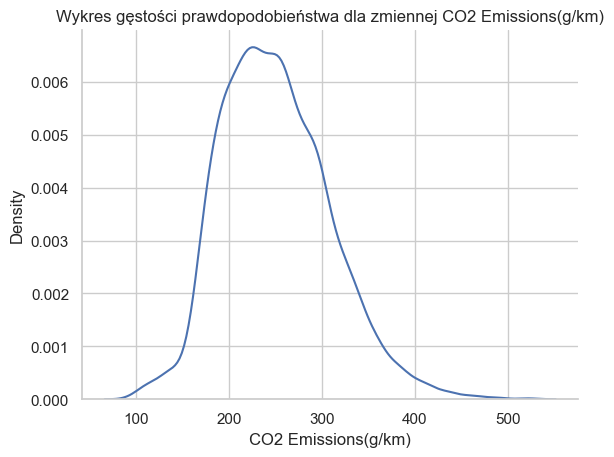

In [176]:
for ContFeature in ContFeatures:
    axes = StwórzWykresKDE(Dataset, ContFeature)
    axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {ContFeature}")

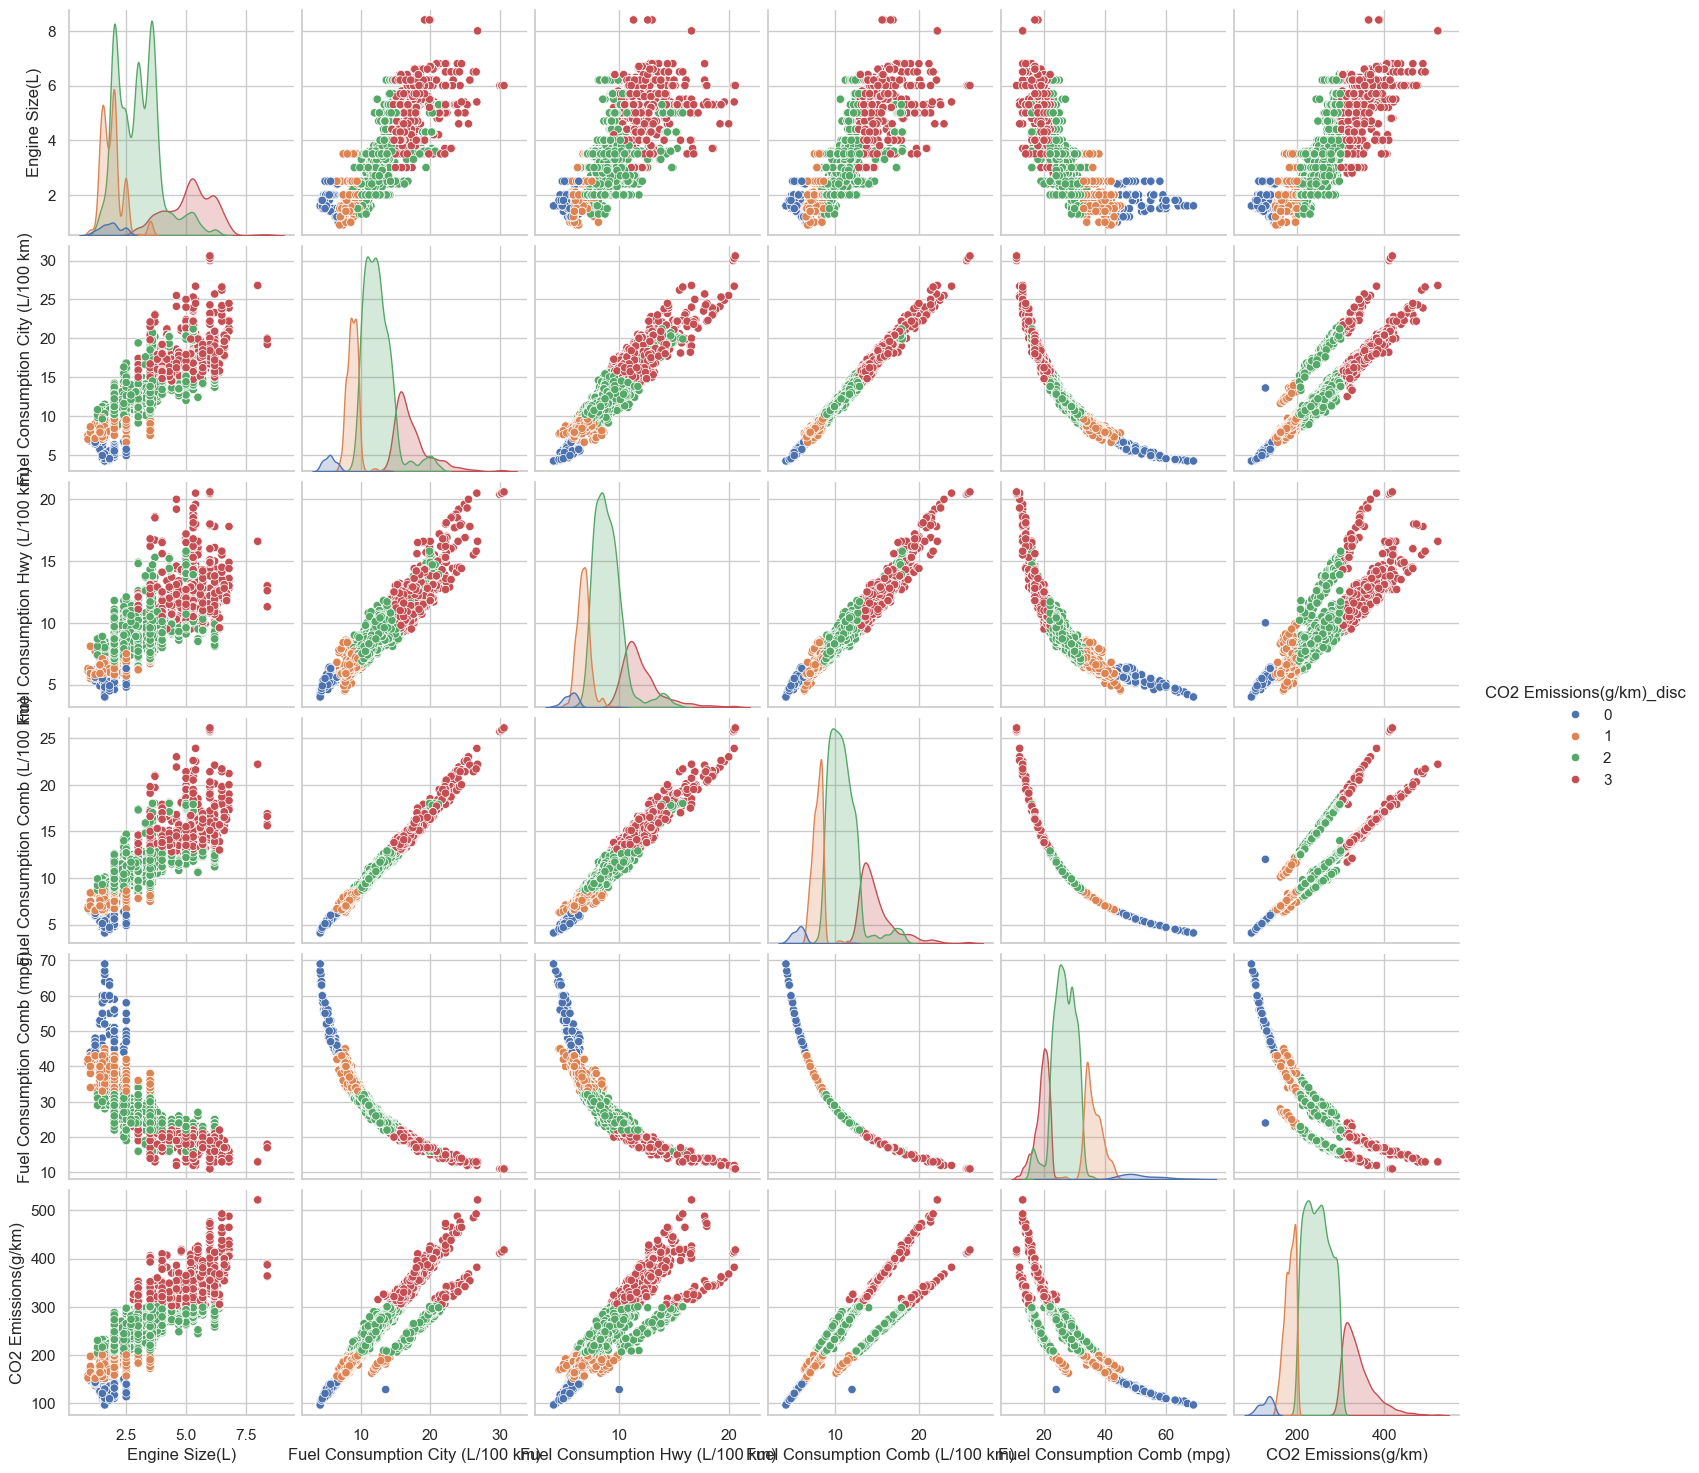

In [177]:
#Teraz stwórz wykres parowy warunkowy ze względu na dyskretną wartość zmiennej docelowej.
sns.pairplot(data = Dataset, vars = ContFeatures , hue = target_var_discr)


### 7. Wykresy pudełkowe dla zmiennych ciągłych.

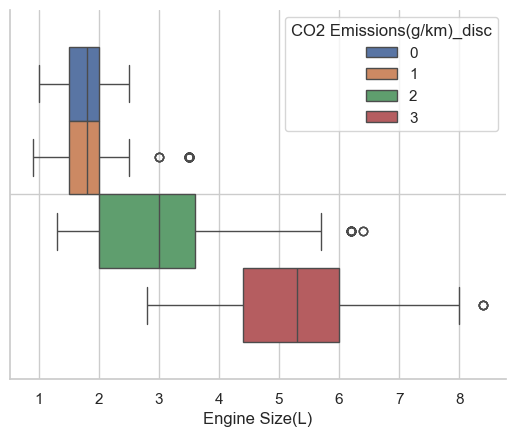

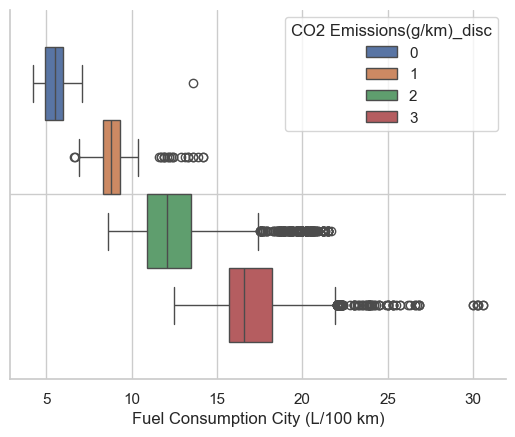

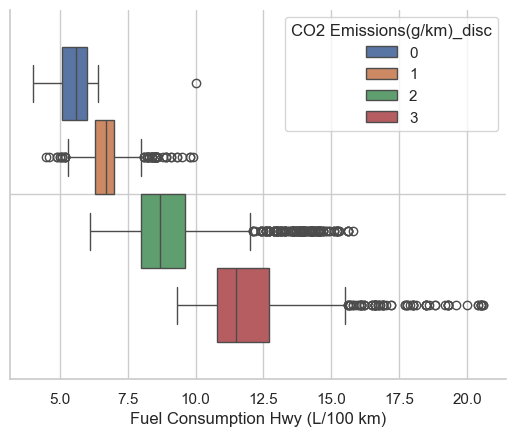

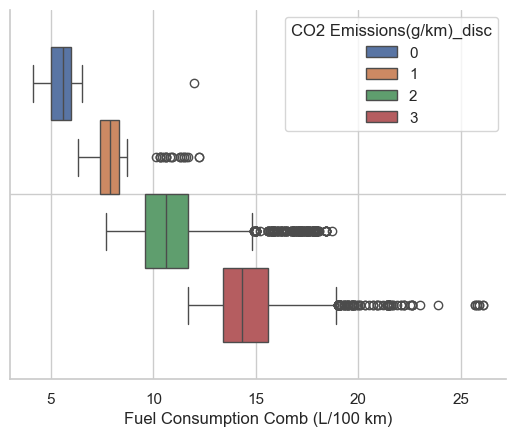

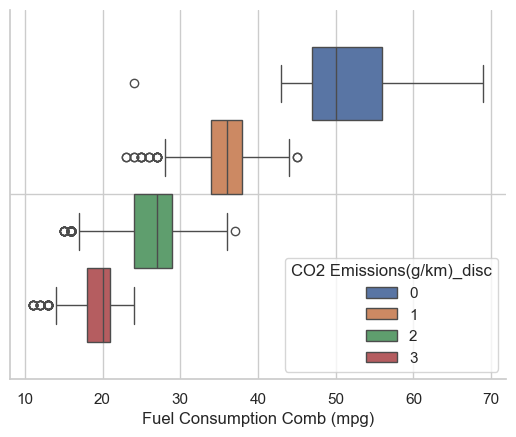

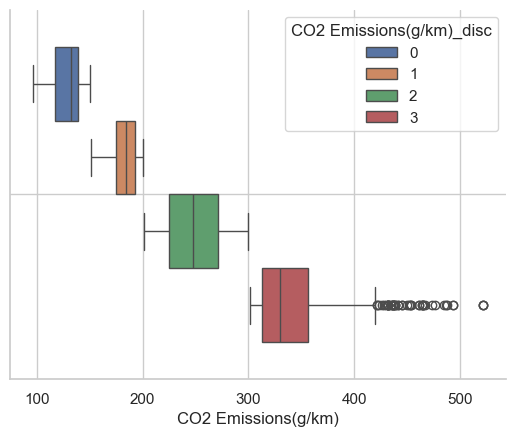

In [178]:
def StwórzWykresPudełkowy(Dataset:pd.DataFrame, ContFeature:str, condfeature:str):
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.boxplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres pudełkowy..

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)


for ContFeature in ContFeatures:
    
    StwórzWykresPudełkowy(Dataset, ContFeature, target_var_discr)

### Powyższe wykresy pudełkowe utwierdzają nas w przekoniu, że te zmienne idealnie spełniają wymagania na bycie predyktorem.

In [179]:
Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type','Fuel Consumption City (L/100 km)']


### 8. Kodowanie zmiennych kategorycznych.

In [180]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def ZakodujDane(Dataset:pd.DataFrame, Predictors:list[str], target_var_discr:str) -> tuple[np.ndarray, np.ndarray]:
    #Określ zestaw cech predykcyjnych.
    X = Dataset[Predictors]
    #Określ cechę celu. Tę kolumne przekształć do tablicy numpy wymiary (n_samples, 1).
    y = Dataset[target_var_discr].to_numpy().reshape(-1,1)

    #Zdefiniuj transformator. Jest on oparty na koderze OneHotEncoder(). Do przekształcenia bierzemy tylko kolumny kategoryczne. Pozostałe kolumny (zmienne ciągłe) są przekazywane 
    #do wyjściowej ramki zmiennych predykcyjnych bez zmian.
    cat_col_transformer = ColumnTransformer(transformers = 
                                            [('cat',OneHotEncoder(sparse_output = False), make_column_selector(dtype_include=['category','object']))],
                                            remainder = "passthrough",)

    #Przekształć zmienną X za pomocą określonego wyżej transformatora.
    X_coded = cat_col_transformer.fit_transform(X = X)

    return X_coded, y


def TransformujDane(Dataset: np.ndarray) -> np.ndarray:
    """Funkcja stosuje standaryzacje dla tablicy, która zawiera już zmienne numeryczne."""
    cont_col_transformer = ColumnTransformer(transformers = [("Scaler", StandardScaler(),  list(range(0, Dataset.shape[1])) )], remainder = "passthrough")

    return cont_col_transformer.fit_transform(X = Dataset)



### Definiowanie modeli, list na ich wyniki, na hiperparametry modeli.

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

# Definicja modeli z hiperparametrami
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=10), 
    "LasLosowy": RandomForestClassifier(n_estimators=50, criterion='gini'), 
    "KNN": KNeighborsClassifier(n_neighbors=50),
    "RegresjaLiniowa": RidgeClassifier(alpha=1)
}

# Słownik do przechowywania wyników modeli
Models_scoresv1 = {model_name: [] for model_name in Models.keys()}
Models_scoresv2 = {model_name: [] for model_name in Models.keys()}


#Słownik do przechowywania hiperparametrów modeli:
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
                                        "splitter":['best','random'],
                                        "min_samples_split":[3,5],
                                        "min_samples_leaf":[2,3]},


                    "LasLosowy":{"n_estimators":list(range(1, 50, 5)),
                                 "criterion":['gini','entropy'],
                                        "min_samples_split":[3,5],
                                        "min_samples_leaf":[2,3]}
                                        ,
                    "KNN": {"n_neighbors":list(range(2, 10, 2)),
                            "p":[1,2]},

                    "RegresjaLiniowa":{'alpha':[0,1,2]}
                        }


### Przygotowanie metody porównaczej.

In [187]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


def TrainAndTestTheModelv1(model_name:str, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    """
    Trenuje model i zwraca jego dokładność na zbiorze testowym. Nie dokonuje się tutaj strojenie parametrów.
    """
    model = Models[model_name]

    model.fit(X_train, y_train.ravel())
    return model.score(X_test, y_test)

def TrainAndTestTheModelv2(model_name:str, param_grid, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    """
    Trenuje model i zwraca jego dokładność na zbiorze testowym. Tutaj strojenie parametrów ma miejsce.
    """
    model = Models[model_name]

    GridSearch = GridSearchCV(estimator = model, param_grid = Models_hipparams[model_name], scoring = "accuracy")
    GridSearch.fit(X  = X_train, y = y_train)

    BestEstimator = GridSearch.best_estimator_
    

    
    return BestEstimator.score(X_test, y_test)


def PlotTheScores(k_iter: int, Models_scores):
    """
    Przedstawia wyniki wszystkich modeli na wykresie liniowym oraz pudełkowym.
    """
    line_figure = plt.figure(figsize=(12, 6))
    box_figure = plt.figure(figsize=(12, 6))
    
    line_axes = line_figure.add_subplot(111)
    
    box_axes = box_figure.add_subplot(111)

    x_axis_values = np.arange(1, k_iter + 1)
    
    Models_name = list(Models_scores.keys())
    Models_scores_list = list(Models_scores.values())

    for model_name, scores in Models_scores.items():
        line_axes.plot(x_axis_values, scores, label=model_name)
    
    line_axes.legend()
    line_axes.set_title("Dokładność modeli w poszczególnych iteracjach")
    line_axes.set_ylabel("Dokładność")
    line_axes.set_xlabel("Iteracja")
    line_axes.grid(True)

    sns.boxplot(data=Models_scores_list, ax=box_axes)
    box_axes.set_xticklabels(Models_name)
    box_axes.set_title("Wykres pudełkowy dokładności modeli")
    box_axes.set_ylabel("Dokładność")

    plt.show()




Porównywanie działania modeli ze statycznie dobranymi hiperparametrami.

C:\Users\pawel\AppData\Local\Temp\ipykernel_19128\3657654122.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_axes.set_xticklabels(Models_name)


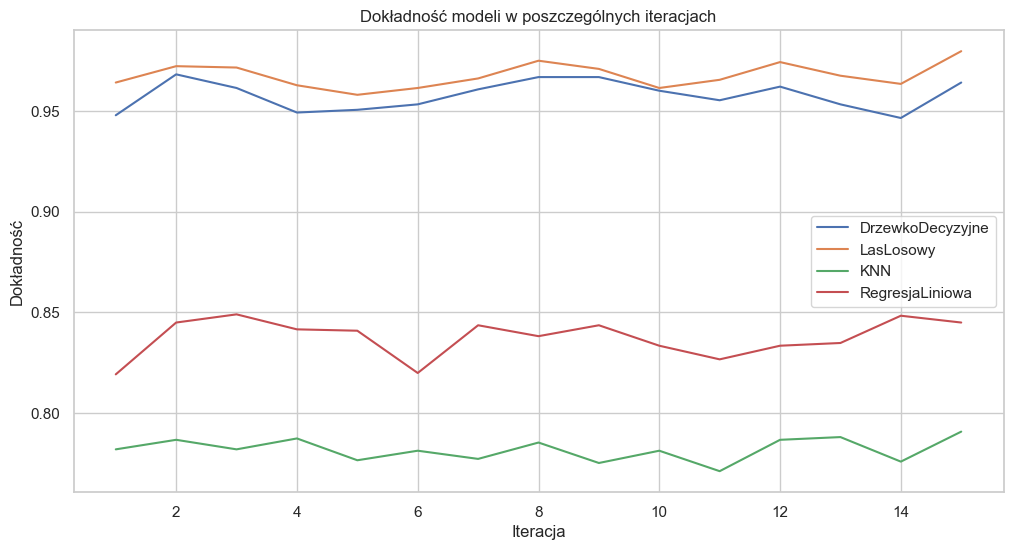

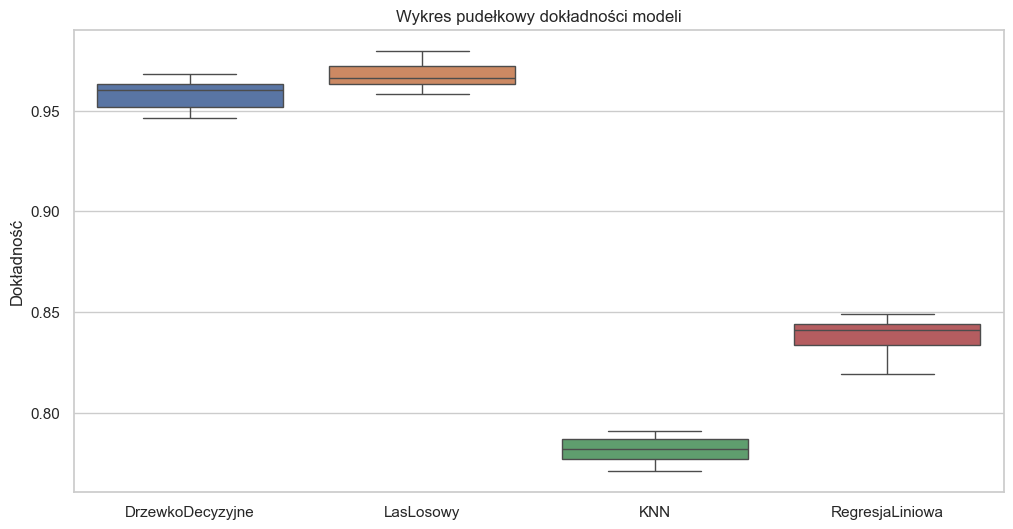

In [188]:
def CompareModelsStaticParams(Dataset: pd.DataFrame, Predictors: list[str], target_var_discr: str, Models, Models_scores,
                              train_size: float = 0.8, test_size: float = 0.2, n_splits: int = 15):
    """
    Porównuje działanie modeli zawartych w słowniku Models.
    Na początek dane kategoryczne są kodowane, a potem następuje stratyfikowany podział szufladkowy n_splits razy.
    """
    sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, test_size=test_size)

    X, y = ZakodujDane(Dataset, Predictors, target_var_discr)  # Zakoduj dane

    for train_indices, test_indices in sss.split(X=X, y=y):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        X_train = TransformujDane(X_train)  # Normalizacja zbioru treningowego
        X_test = TransformujDane(X_test)    # Normalizacja zbioru testowego
        
        for model_name, model in Models.items():
            score = TrainAndTestTheModelv1(model_name, X_train, X_test, y_train, y_test)
            
            Models_scores[model_name].append(score)
        
    PlotTheScores(n_splits, Models_scores)


# Przyklad wywołania funkcji
CompareModelsStaticParams(Dataset, Predictors, target_var_discr, Models, Models_scoresv1)


### Porównywanie działania modeli z dynamicznie dobranymi parametrami.

0
1
2
3
4


C:\Users\pawel\AppData\Local\Temp\ipykernel_19128\3657654122.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_axes.set_xticklabels(Models_name)


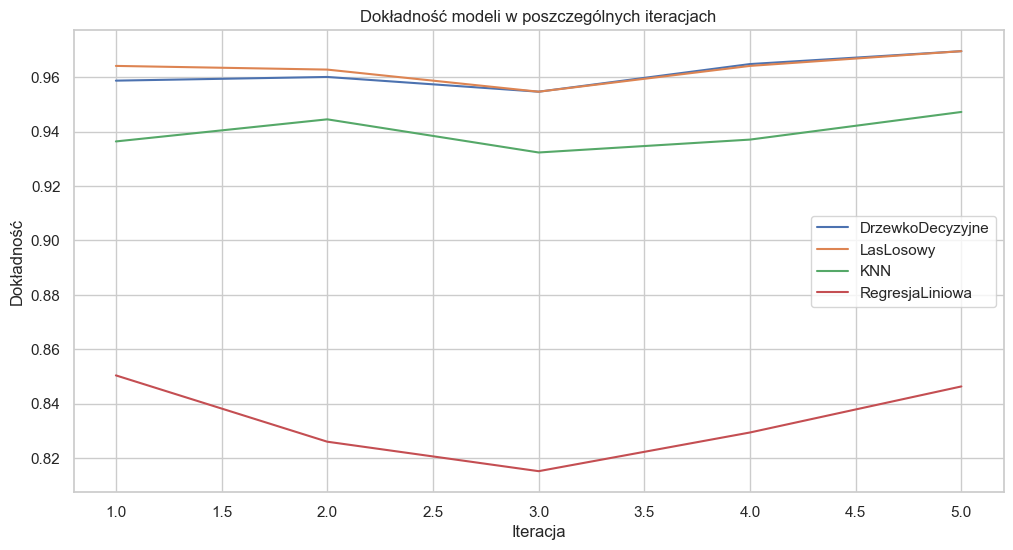

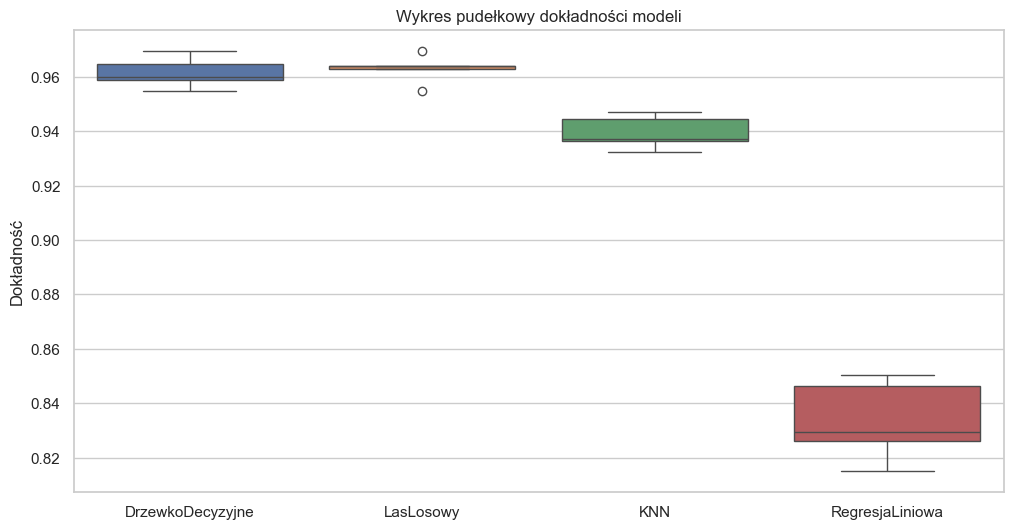

In [189]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import numpy as np


def TrainAndTestTheModelv2(model_name: str, param_grid, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    """
    Trenuje model i zwraca jego dokładność na zbiorze testowym po strojeniu parametrów.
    """
    model = Models[model_name]
    
    # Użyj parametrów param_grid dla GridSearchCV
    GridSearch = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy")
    GridSearch.fit(X=X_train, y=y_train)
    
    BestEstimator = GridSearch.best_estimator_
    
    return BestEstimator.score(X_test, y_test)


def CompareModelsDynamicParams(Dataset: pd.DataFrame, Predictors: list[str], target_var_discr: str, Models, Models_hipparams,
                              Models_scores, train_size: float = 0.8, test_size: float = 0.2, n_splits: int = 5):
    """
    Porównuje działanie modeli zawartych w słowniku Models po strojeniu parametrów.
    Na początek dane kategoryczne są kodowane, a potem następuje stratyfikowany podział szufladkowy n_splits razy.
    """
    sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, test_size=test_size, random_state=42)
    
    X, y = ZakodujDane(Dataset, Predictors, target_var_discr)  # Zakoduj dane
    i=0

    for train_indices, test_indices in sss.split(X=X, y=y):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Normalizacja zbioru treningowego i testowego osobno
        X_train = TransformujDane(X_train)
        X_test = TransformujDane(X_test)

        for model_name, model in Models.items():
            # Strojenie parametrów dla danego modelu
            param_grid = Models_hipparams[model_name]  # Pobierz parametry dla modelu

            score = TrainAndTestTheModelv2(model_name, param_grid, X_train, X_test, y_train.ravel(), y_test.ravel())

            Models_scores[model_name].append(score)

        print(i)
        i+=1

    PlotTheScores(n_splits, Models_scores)

        

CompareModelsDynamicParams(Dataset, Predictors, target_var_discr, Models, Models_hipparams, Models_scoresv2)

